## Supermarket Data Dive
My task was open-ended: to pull actionable insights from a large dataset containing geographical information about points of sale for supermarket products, for thousands of customers and thousands of products. Store distances were a calculated in meters as a straight line. Purchases were recorded from January 2007 to December 2011.

### Importing and Cleaning

I started by importing the necessary python modules:

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import statsmodels.stats.api as sms
from scipy.stats import linregress

I received the data as a .csv ('supermarket_data_aggr.csv'). I imported the dataset and loaded it into a pandas DataFrame:

In [117]:
df = pd.read_csv('supermarket_data_aggr.csv')

I began by removing rows with missing values (only 1 row), and looking at some descriptive statistics of each column.

In [118]:
print('Before cleaning: ' + str(len(df.index)) + ' rows of data')
df_clean = df.dropna()
print('After cleaning:  ' + str(len(df_clean.index)) + ' rows of data')
df_clean[['min_distance_to_shops','max_distance_to_shops','shops_used','avg_purchase','amount_purchased']].describe()

Before cleaning: 60366 rows of data
After cleaning:  60365 rows of data


,min_distance_to_shops,max_distance_to_shops,shops_used,avg_purchase,amount_purchased
count,60365.000000,60365.000000,60365.000000,60365.000000,60365.000000
mean,1396.438077,2942.667579,2.380055,8.532106,4235.493251
std,1048.415728,1327.528871,1.012191,10.315527,5006.777082
min,6.642472,6.642472,1.000000,0.212000,0.212000
25%,573.610700,2117.183000,2.000000,4.532897,653.107000
50%,1184.943000,2869.195300,2.000000,6.862780,2355.138000
75%,1962.384500,3580.669700,3.000000,10.429567,6054.631000
max,9004.164000,9267.698000,5.000000,787.569000,51588.656000


### Dataset Exploration
As the dataset contained data from each of five stores, I designed my data exploration to allow for comparison of the performance of each of these stores to each other in terms of 1) total sales 2) average distance to customer.

In [119]:
# Prepare to create bar plots
labels = ['Store #1', 'Store #2', 'Store #3', 'Store #4', 'Store #5']
xaxis = range(0,len(labels))
%matplotlib inline
plt.style.use('ggplot')

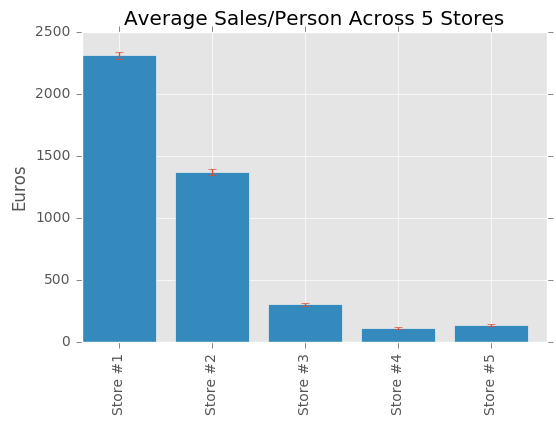

In [120]:
# Plot total sales
yaxis = [0] * 5
ystde = [0] * 5
for i in range(5):
    var_name = 'amount_purchased_shop_' + str(i+1)
    yaxis[i] = np.mean(df_clean[var_name])
    ystde[i] = sms.DescrStatsW(df_clean[var_name]).tconfint_mean()[1]-np.mean(df_clean[var_name])
_ = plt.bar((xaxis), yaxis, yerr=ystde)
_, lbls = plt.xticks([x+.4 for x in xaxis], labels)
_ = plt.setp(lbls, rotation=90)
_ = plt.title('Average Sales/Person Across 5 Stores')
_ = plt.ylabel('Euros')

Stores #1 and #2 make of a large majority of the supermarket chain's sales, but this should be interpreted in the context of logically contributing factors, such as each store's distance from the average customer:

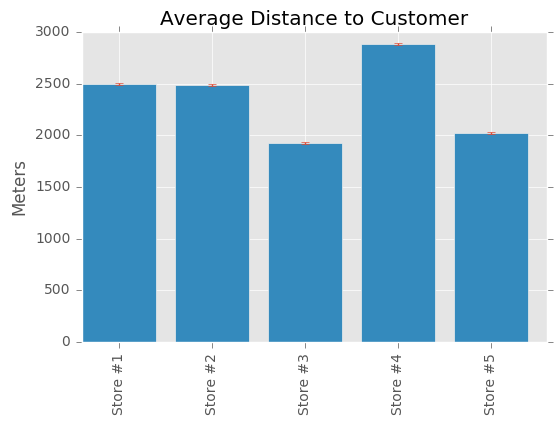

In [121]:
# Plot average distance to customer
yaxis = [0] * 5
ystde = [0] * 5
for i in range(5):
    var_name = 'distance_shop_' + str(i+1)
    yaxis[i] = np.mean(df_clean[var_name])
    ystde[i] = sms.DescrStatsW(df_clean[var_name]).tconfint_mean()[1]-np.mean(df_clean[var_name])
_ = plt.bar((xaxis), yaxis, yerr=ystde)
_, lbls = plt.xticks([x+.4 for x in xaxis], labels)
_ = plt.setp(lbls, rotation=90)
_ = plt.title('Average Distance to Customer')
_ = plt.ylabel('Meters')

While there does seem to be quite a bit of variability between these stores in their distance from customers on average, there does not seem to be a trend that matches the clear ordering of the stores in terms of average sales. I ran a correlation between average sales and average distance to be sure (indeed: no significant relationship; p > 0.05):

In [122]:
paid = [0] * 5
dist = [0] * 5
for i in range(5):
    var_name_P = 'amount_purchased_shop_' + str(i+1)
    paid[i] = np.mean(df_clean[var_name_P])
    var_name_D = 'distance_shop_' + str(i+1)
    dist[i] = np.mean(df_clean[var_name_D])
correlation_result = linregress(paid, dist)
print('CORRELATION(SALES, DISTANCE):')
print('COEF = {:.5f}  PVAL = {:.3f}'.format(correlation_result.rvalue, correlation_result.pvalue))

CORRELATION(SALES, DISTANCE):
COEF = 0.23669  PVAL = 0.701


### Modeling Customer Spending
Since a supermarket's goal is to maximize the amount that each customer spends (i.e. amount_purchased), I next fit a linear regression to look at the relationship between the amount that each customer spends and some potentially influencing factors: 1) their distance to closest store (min_distance_to_shops) 2) the number of stores they used (shops_used).

In [123]:
X = df_clean.as_matrix(columns = ['min_distance_to_shops','shops_used'])
Y_prenorm = df_clean['amount_purchased']
Y = Y_prenorm / Y_prenorm.max(axis=0)

linear_reg = LinearRegression(normalize=True)
linear_reg = linear_reg.fit(X, Y)
_, pvals = f_regression(X, Y)

Below are some summary statistics of this regression fit. A customer's minimum distance to a store has a negligible (although technically significant) inverse relationship with total spending. In addition, customers that shop at a greater variety of the supermarket's locations do seem to spend significantly more per year.

In [124]:
print('LINEAR REGRESSION PREDICTORS:')
print('min_distance_to_shops  COEF = {: .5f}  PVAL = {:.3f}'.format(linear_reg.coef_[0], pvals[0]))
print('shops_used             COEF = {: .5f}  PVAL = {:.3f}'.format(linear_reg.coef_[1], pvals[1]))

LINEAR REGRESSION PREDICTORS:
min_distance_to_shops  COEF = -0.00001  PVAL = 0.000
shops_used             COEF =  0.02334  PVAL = 0.000


### Conclusions
Despite being collected over the course of 4 years, the dataset did not label purchases from different time periods, eliminating analysis of purchase patterns across time as a possibility. That being said, the dataset distinguished between data taken from 5 different stores, allowing for between-store comparisons. Analyzing overall sales patterns, I showed that Store #1 (and to a lesser extent Store #2) is more profittable than the other stores, an effect that does not seem to be a function of proximity to customers. If the store numbering corresponds to store opening dates, I would venture a guess that the primary driver of this effect is store legacy, i.e. people have had more time to incorporate older stores into their routines.

To dig a bit deeper into store success, I modeled sales per customer as a function of their minimum distance to a store, and the number of stores they made purchases at. Contrary to my expectation, minimum distance to a store did not strongly predict overall purchase amount. On the other hand, more stores visited did indeed increase overall purchase amount.

These findings could be useful when determining where to place new stores. Evidently, trying to decrease each customer's minimum distance to a store is not worthwhile. Instead, maximizing the number of stores within a customer's general area seems like it would better support increased overall sales. 